# LNG TTF Spot Price Forecasting

## Project Objective
To forecast monthly TTF natural gas prices (not strictly spot LNG) using:
* US LNG export data
* EU gas import volumes
* Global gas benchmarks (Henry Hub, JKM)
* Regional temperatures (proxy for demand)

## Outcome
📘 XGBoost Regressor


* R² on test set: 0.749
* MAE: 1.83 | RMSE: 2.38
* Captures key patterns from lagged pricing and arbitrage spreads
* Supports practical trading insights and macroeconomic analysis


🌲 Random Forest Regressor
* R² on test set: 0.872
* MAE: 1.34 | RMSE: 1.70
* Stronger fit on test set but higher risk of overfitting
* Useful for prototyping pricing signals and model benchmarking


## Quick Insights


* TTF is structurally higher than Henry Hub due to import reliance and volatility
* Arbitrage signals (e.g., TTF − HH spreads) correlate well with price movements
* Post-2021, EU’s gas dependency and global events (e.g., Russia-Ukraine) drove sharp price divergence
* Monthly average temperatures influence seasonal demand and pricing


## Assumptions

* TTF pricing data reflects monthly average natural gas prices, not direct LNG spot cargo indexes
* Gas imports (mmcm) and LNG exports (mmcf) serve as demand/supply proxies
* Regional temperatures are used as demand indicators
* Prices used may include hub/futures influences, not physical LNG cargoes


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")

## Data Loading

In [50]:
brent_oil=pd.read_csv('/kaggle/input/lng-price/Brent Oil Futures Historical Data.csv')
ttf_price=pd.read_csv('/kaggle/input/lng-price/Dutch TTF Natural Gas Futures Historical Data.csv')
europe_gas_imports_mmcm=pd.read_csv('/kaggle/input/lng-price/Europe Natural Gas Imports MMcm.csv', encoding='cp1252')
monthly_weather_data = pd.read_csv('/kaggle/input/weather-data/monthly_avg_temperatures_2020_2024.csv')
henry_hub_price=pd.read_csv('/kaggle/input/lng-price/Henry_Hub_Natural_Gas_Spot_Price.csv')
us_lng_exports_mmcf=pd.read_csv('/kaggle/input/lng-price/Liquefied_U.S._Natural_Gas_Exports.csv')
jkm_price=pd.read_csv('/kaggle/input/lng-price/LNG Japan_Korea Marker PLATTS Future Historical Data.csv')

## Load and reshape EU gas imports data

In [51]:
# Transpose and clean initial EU gas imports dataset
eu_gas_imports_cleaned = europe_gas_imports_mmcm.loc[:, ~europe_gas_imports_mmcm.columns.str.contains(r'Unnamed: \d{1,3}', regex=True)]
eu_gas_imports_cleaned_transposed = eu_gas_imports_cleaned.T.iloc[:207]
eu_gas_imports_cleaned_transposed = eu_gas_imports_cleaned_transposed.iloc[:, 1:].copy()
eu_gas_imports_cleaned_transposed['Month'] = pd.date_range(start='2008-01-01', end='2025-03-01', freq='MS')
eu_gas_imports_cleaned_transposed.set_index('Month', inplace=True)

# Convert the transposed frame into a proper format
df = eu_gas_imports_cleaned_transposed.reset_index()
df.columns = df.iloc[0]
df = df[1:]
df.rename(columns={df.columns[0]: 'Month'}, inplace=True)
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
df.reset_index(drop=True, inplace=True)
df.columns = df.columns.str.encode('utf-8').str.decode('utf-8', errors='replace')
df.set_index('Month', inplace=True)

# Filter by date and clean values
df_eu_imports_filtered = df.loc['2020-01':'2024-12']
df_eu_imports_filtered = df_eu_imports_filtered.apply(lambda col: col.astype(str).str.replace(',', '').str.strip())
df_eu_imports_filtered = df_eu_imports_filtered.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
df_eu_imports_filtered.rename(columns={'TÃ¼rkiye': 'Turkey'}, inplace=True)


In [52]:
df_eu_imports_filtered.head()

,Belgium,Bulgaria,Czechia,Denmark,Germany,Estonia,Ireland,Greece,Spain,France,...,United Kingdom,Montenegro,Moldova,North Macedonia,Georgia,Albania,Serbia,Turkey,Ukraine,Kosovo*
Month,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4258,863,2938,309,14955,65,273,393,3209,4939,...,5850,0,0,0,367,0,294,5417,0,0
2020-02-01,3646,616,3953,176,15329,53,302,605,2878,3399,...,4003,0,175,40,419,0,278,5988,380,0
2020-03-01,4222,455,3589,192,13971,49,282,533,2610,3713,...,4252,0,145,25,350,0,252,5261,877,0
2020-04-01,4832,507,3721,233,14008,50,297,401,2793,4339,...,5267,0,110,15,224,0,226,3941,1126,0
2020-05-01,3914,421,3422,212,13002,36,247,374,2069,5353,...,3530,0,63,12,186,0,57,2501,472,0


## Clean weather data

In [53]:
monthly_weather_data.info()
for column in monthly_weather_data.columns[1:]:
    mean_value = monthly_weather_data[column].mean()
    monthly_weather_data[column].fillna(mean_value, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            60 non-null     object 
 1   France          59 non-null     float64
 2   Netherlands     55 non-null     float64
 3   Spain           59 non-null     float64
 4   Italy           59 non-null     float64
 5   Turkey          60 non-null     float64
 6   United Kingdom  59 non-null     float64
 7   Belgium         58 non-null     float64
 8   Germany         60 non-null     float64
 9   Poland          59 non-null     float64
dtypes: float64(9), object(1)
memory usage: 4.8+ KB


## Clean price and volume datasets

In [54]:
# STEP 1: Convert 'Month' to datetime
us_lng_exports_mmcf['Date'] = pd.to_datetime(us_lng_exports_mmcf['Month'], format='%b-%y')

# STEP 2: Sort dates in ascending order (oldest to newest)
us_lng_exports_mmcf = us_lng_exports_mmcf.sort_values('Date').reset_index(drop=True)

# STEP 3: Filter from Jan 2020 onwards (to match rest of the data)
us_lng_exports_mmcf = us_lng_exports_mmcf[us_lng_exports_mmcf['Date'] >= '2020-01-01']

# STEP 4: Keep only relevant columns for merge
us_lng_exports_mmcf = us_lng_exports_mmcf[['Date', 'Liquefied U.S. Natural Gas Exports  Million Cubic Feet']]


In [55]:
#Brent Oil
brent_oil['Date'] = pd.to_datetime(brent_oil['Date'], dayfirst=True, errors='coerce')
brent_oil = brent_oil.drop(columns=['Vol.', 'Change %'], errors='ignore')
brent_oil = brent_oil.sort_values('Date').reset_index(drop=True)

# TTF
ttf_price['Date'] = pd.to_datetime(ttf_price['Date'], dayfirst=True, errors='coerce')
ttf_price = ttf_price.drop(columns=['Vol.', 'Change %'], errors='ignore')
ttf_price = ttf_price.sort_values('Date').reset_index(drop=True)

# HH monthly average
monthly_avg = henry_hub_price.groupby(pd.to_datetime(henry_hub_price['Week of']).dt.to_period('M'))['Henry Hub Natural Gas Spot Price Dollars per Million Btu'].mean().reset_index().rename(columns={'Week of': 'Month', 'Henry Hub Natural Gas Spot Price Dollars per Million Btu': 'Avg Henry Hub Price'})
monthly_avg['Month'] = monthly_avg['Month'].dt.to_timestamp()
monthly_avg = monthly_avg[(monthly_avg['Month'] >= '2020-01-01') & (monthly_avg['Month'] <= '2024-12-31')]

# JKM
jkm_price['Date'] = pd.to_datetime(jkm_price['Date'], dayfirst=True)
jkm_price = jkm_price.drop(columns=['Vol.', 'Change %'], errors='ignore')
jkm_price['Month'] = jkm_price['Date'].dt.to_period('M')
monthly_avg_jkm = jkm_price.groupby('Month').mean(numeric_only=True).reset_index()
monthly_avg_jkm['Month'] = monthly_avg_jkm['Month'].dt.to_timestamp()
monthly_avg_jkm.rename(columns={'Month': 'Date'}, inplace=True)
monthly_avg_jkm = monthly_avg_jkm.sort_values('Date').reset_index(drop=True)

# US Exports
ttf_price = ttf_price[['Date', 'Price']].copy()
monthly_avg_jkm = monthly_avg_jkm[['Date', 'Price']].copy()
brent_oil = brent_oil[['Date', 'Price']].copy()

# EU imports cleanup
df_eu_imports_filtered = df_eu_imports_filtered.reset_index()
df_eu_imports_filtered.rename(columns={df_eu_imports_filtered.columns[0]: 'Date'}, inplace=True)

# Drop duplicate 'Date' columns if any
def clean_date_duplicates(df):
    date_like_cols = [col for col in df.columns if 'Date' in col and col != 'Date']
    return df.drop(columns=date_like_cols, errors='ignore')

# Apply cleanup to all datasets
datasets = [df_eu_imports_filtered, monthly_weather_data, brent_oil, ttf_price, monthly_avg, monthly_avg_jkm, us_lng_exports_mmcf]
datasets = [clean_date_duplicates(df) for df in datasets]

# Convert 'Date' columns to datetime
for df in datasets:
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Unpack
(
    df_eu_imports_filtered, monthly_weather_data, brent_oil,
    ttf_price, monthly_avg, monthly_avg_jkm, us_lng_exports_mmcf
) = datasets

# Rename Month to Date where necessary
for df in [df_eu_imports_filtered, monthly_avg, us_lng_exports_mmcf]:
    if 'Month' in df.columns:
        df.rename(columns={'Month': 'Date'}, inplace=True)


## Merge datasets

In [56]:
# Forcefully convert 'Date' column to datetime in all datasets
for df in [df_eu_imports_filtered, monthly_weather_data, brent_oil, ttf_price, monthly_avg, monthly_avg_jkm, us_lng_exports_mmcf]:
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [57]:
merged_df = df_eu_imports_filtered \
    .merge(monthly_weather_data, on='Date', how='inner') \
    .merge(brent_oil, on='Date', how='inner', suffixes=('', '_brent')) \
    .merge(ttf_price, on='Date', how='inner', suffixes=('', '_ttf')) \
    .merge(monthly_avg, on='Date', how='inner') \
    .merge(monthly_avg_jkm, on='Date', how='inner', suffixes=('', '_jkm')) \
    .merge(us_lng_exports_mmcf, on='Date', how='inner')

# Rename columns logically
non_country_cols = [
    'Date', 'Price', 'Price_ttf', 'Avg Henry Hub Price',
    'Price_jkm', 'Liquefied U.S. Natural Gas Exports  Million Cubic Feet'
]

def rename_column(col):
    if col in non_country_cols:
        return col
    elif col.endswith('_gas_imports_mmcm') or col.endswith('_avg_C_temperature'):
        return col
    elif col.endswith('_x'):
        return col.replace('_x', '_gas_imports_mmcm')
    elif col.endswith('_y'):
        return col.replace('_y', '_avg_C_temperature')
    else:
        return f'{col}_gas_imports_mmcm'


merged_df = merged_df.rename(columns=rename_column)

merged_df.columns = merged_df.columns.str.strip().str.replace(' ', '_')

In [58]:
print(merged_df.head())

        Date  Belgium_gas_imports_mmcm  Bulgaria_gas_imports_mmcm  \
0 2020-04-01                      4832                        507   
1 2020-05-01                      3914                        421   
2 2020-06-01                      4676                        509   
3 2020-07-01                      3704                        480   
4 2020-09-01                      2430                        567   

   Czechia_gas_imports_mmcm  Denmark_gas_imports_mmcm  \
0                      3721                       233   
1                      3422                       212   
2                      3370                       231   
3                      3904                       233   
4                      4499                       210   

   Germany_gas_imports_mmcm  Estonia_gas_imports_mmcm  \
0                     14008                        50   
1                     13002                        36   
2                     12768                        25   
3             

In [59]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 54 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Date                                                    41 non-null     datetime64[ns]
 1   Belgium_gas_imports_mmcm                                41 non-null     int64         
 2   Bulgaria_gas_imports_mmcm                               41 non-null     int64         
 3   Czechia_gas_imports_mmcm                                41 non-null     int64         
 4   Denmark_gas_imports_mmcm                                41 non-null     int64         
 5   Germany_gas_imports_mmcm                                41 non-null     int64         
 6   Estonia_gas_imports_mmcm                                41 non-null     int64         
 7   Ireland_gas_imports_mmcm                                41 non-n

## EDA (Exploratory Data Analysis)

### Correlation Heatmap

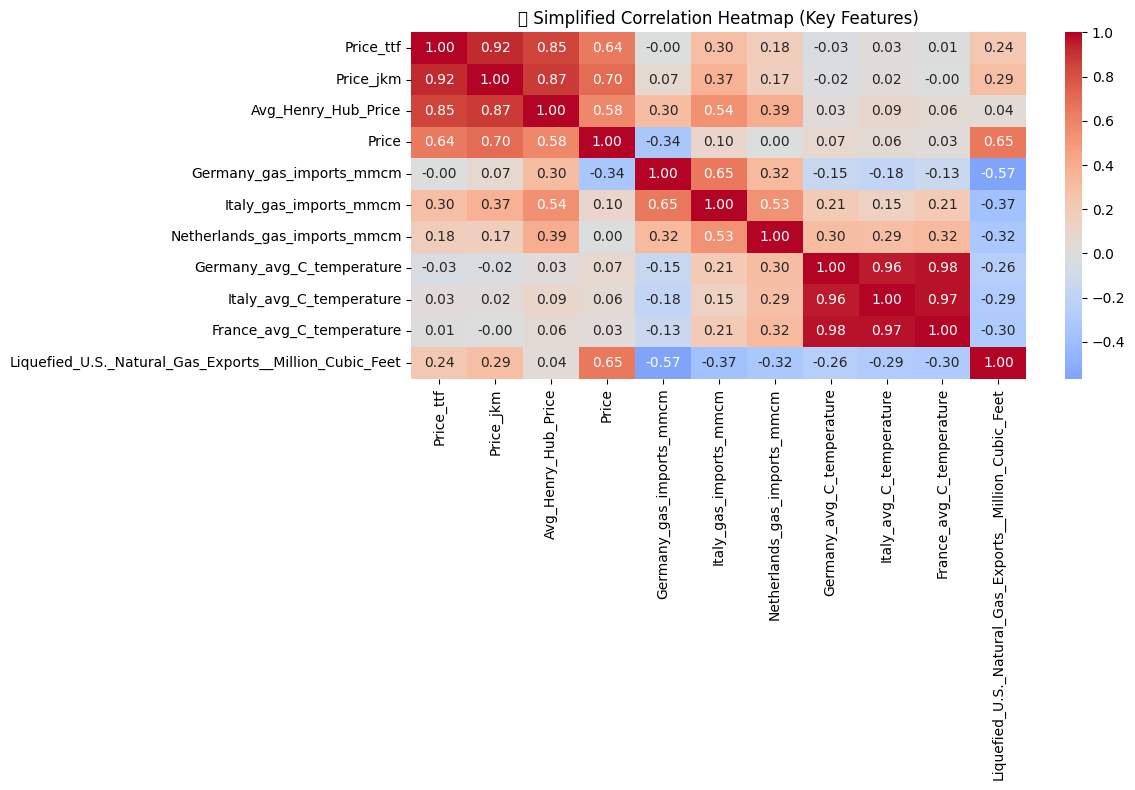

In [60]:
# Define subset of important columns
corr_cols = [
    'Price_ttf',
    'Price_jkm',
    'Avg_Henry_Hub_Price',
    'Price',  # Brent
    'Germany_gas_imports_mmcm',
    'Italy_gas_imports_mmcm',
    'Netherlands_gas_imports_mmcm',
    'Germany_avg_C_temperature',
    'Italy_avg_C_temperature',
    'France_avg_C_temperature',
    'Liquefied_U.S._Natural_Gas_Exports__Million_Cubic_Feet'
]

# Compute correlation matrix
corr_matrix = merged_df[corr_cols].corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("🔍 Simplified Correlation Heatmap (Key Features)")
plt.tight_layout()
plt.show()


### TTF vs JKM vs HH vs Brent (Trend Over Time)

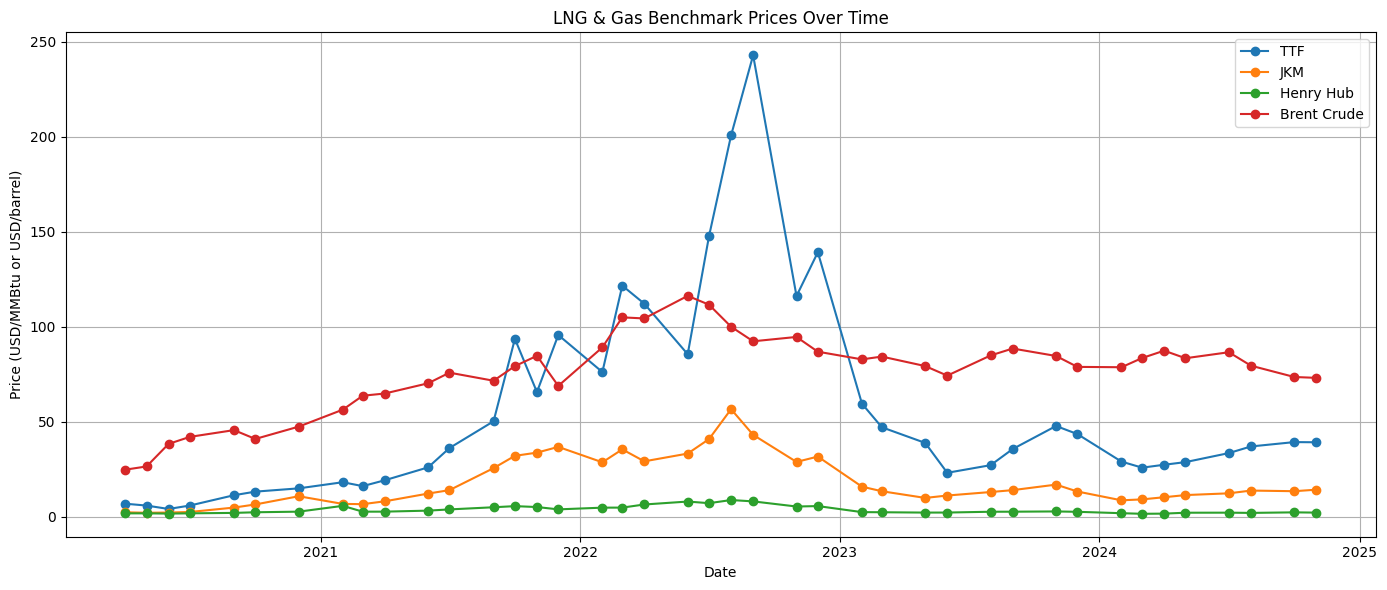

In [61]:
plt.figure(figsize=(14,6))
plt.plot(merged_df['Date'], merged_df['Price_ttf'], label='TTF', marker='o')
plt.plot(merged_df['Date'], merged_df['Price_jkm'], label='JKM', marker='o')
plt.plot(merged_df['Date'], merged_df['Avg_Henry_Hub_Price'], label='Henry Hub', marker='o')
plt.plot(merged_df['Date'], merged_df['Price'], label='Brent Crude', marker='o')
plt.title("LNG & Gas Benchmark Prices Over Time")
plt.ylabel("Price (USD/MMBtu or USD/barrel)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**LNG arbitrage trades rely on spreads between production hubs like HH and demand hubs like TTF/JKM. Post-2021, spreads widened enough to justify shipping even with high freight rates.**

### TTF LNG Spot Price Plot with Russia-Ukraine War Marker + Seasonal Decomposition

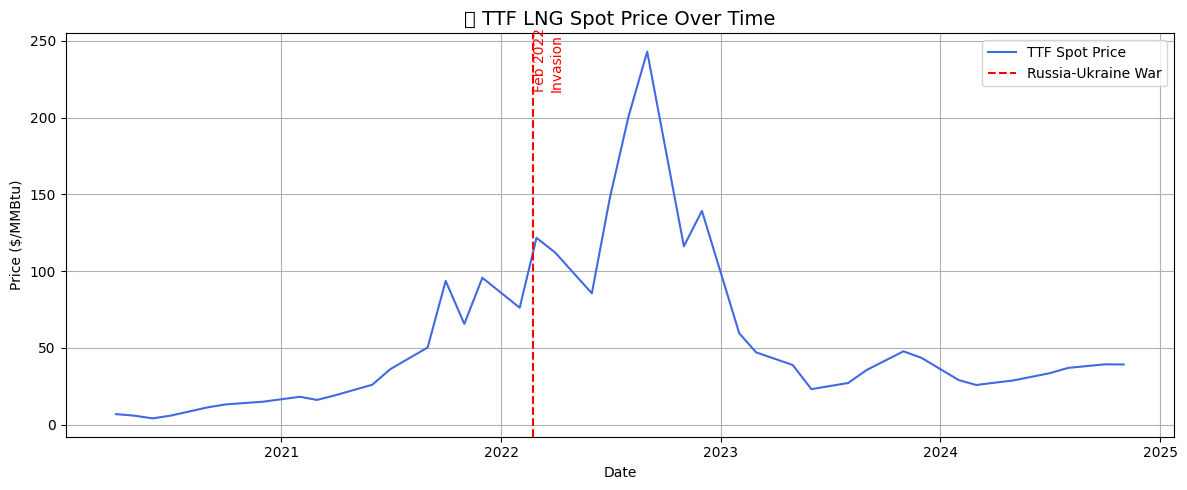

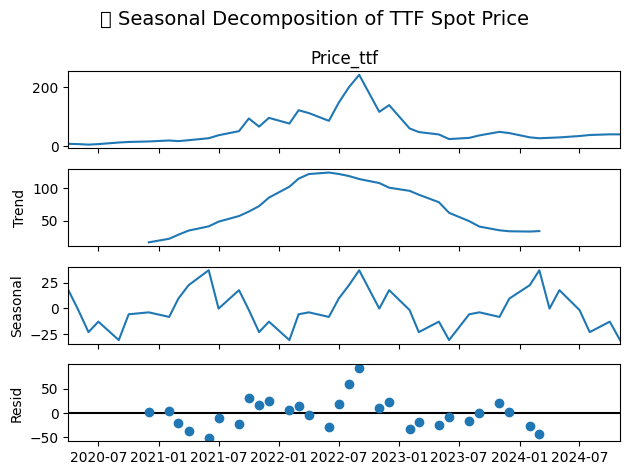

In [62]:
merged_df = merged_df.sort_values('Date')  # sort chronologically just in case
merged_df.set_index('Date', inplace=True)

# Line plot: TTF Spot Price with war annotation
plt.figure(figsize=(12, 5))
plt.plot(merged_df.index, merged_df['Price_ttf'], label='TTF Spot Price', color='royalblue')
plt.axvline(pd.Timestamp('2022-02-24'), color='red', linestyle='--', label='Russia-Ukraine War')
plt.text(pd.Timestamp('2022-02-24'), merged_df['Price_ttf'].max()*0.9, 'Feb 2022\nInvasion', rotation=90, color='red')

plt.title('📈 TTF LNG Spot Price Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Seasonal decomposition
decomp = seasonal_decompose(merged_df['Price_ttf'], model='additive', period=12)  # monthly data, so period=12
decomp.plot()
plt.suptitle('📉 Seasonal Decomposition of TTF Spot Price', fontsize=14)
plt.tight_layout()
plt.show()

merged_df.reset_index(inplace=True)


**From 2016 to 2019, TTF, JKM, and Henry Hub prices were relatively aligned due to global LNG oversupply, low freight costs, and stable demand. Post-2020, especially during the Russia-Ukraine war, prices decoupled sharply — with TTF and JKM spiking due to import dependence and geopolitical risk. This created significant arbitrage spreads, especially from the U.S. into Europe and Asia.**

### US LNG Exports vs TTF Price

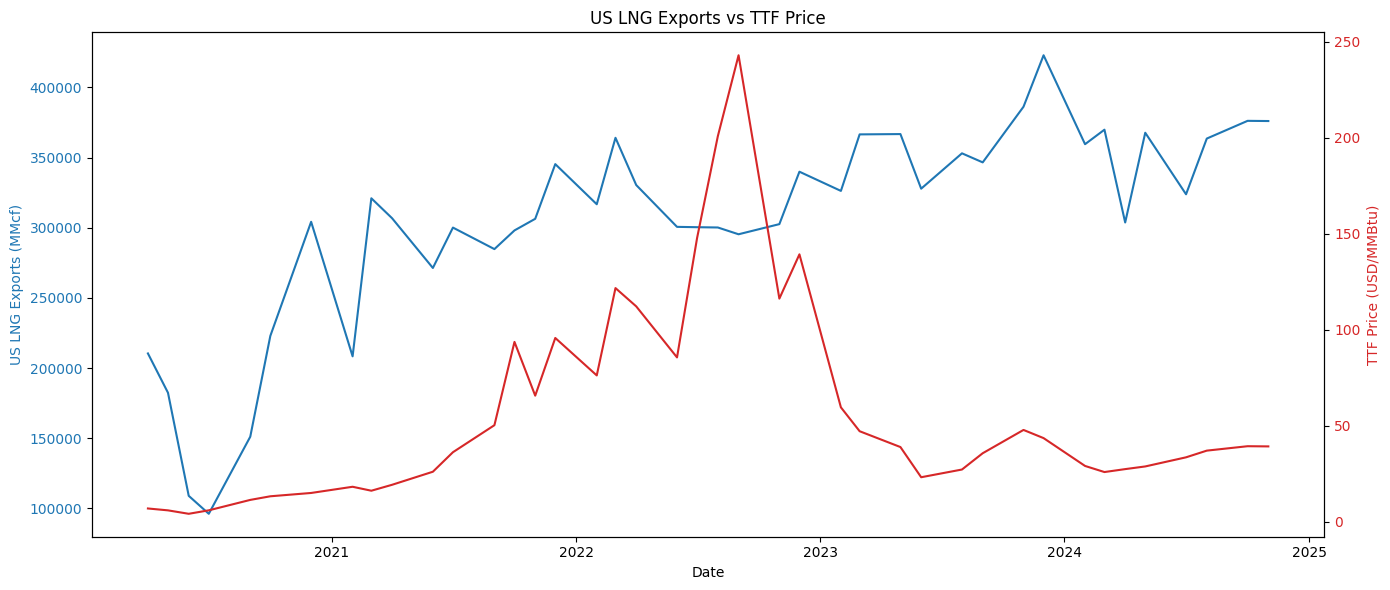

In [63]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('US LNG Exports (MMcf)', color='tab:blue')
ax1.plot(merged_df['Date'], merged_df['Liquefied_U.S._Natural_Gas_Exports__Million_Cubic_Feet'], color='tab:blue', label='US LNG Exports')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('TTF Price (USD/MMBtu)', color='tab:red')
ax2.plot(merged_df['Date'], merged_df['Price_ttf'], color='tab:red', label='TTF Price')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("US LNG Exports vs TTF Price")
fig.tight_layout()
plt.show()


### Rolling Average of TTF Price (3-month window)

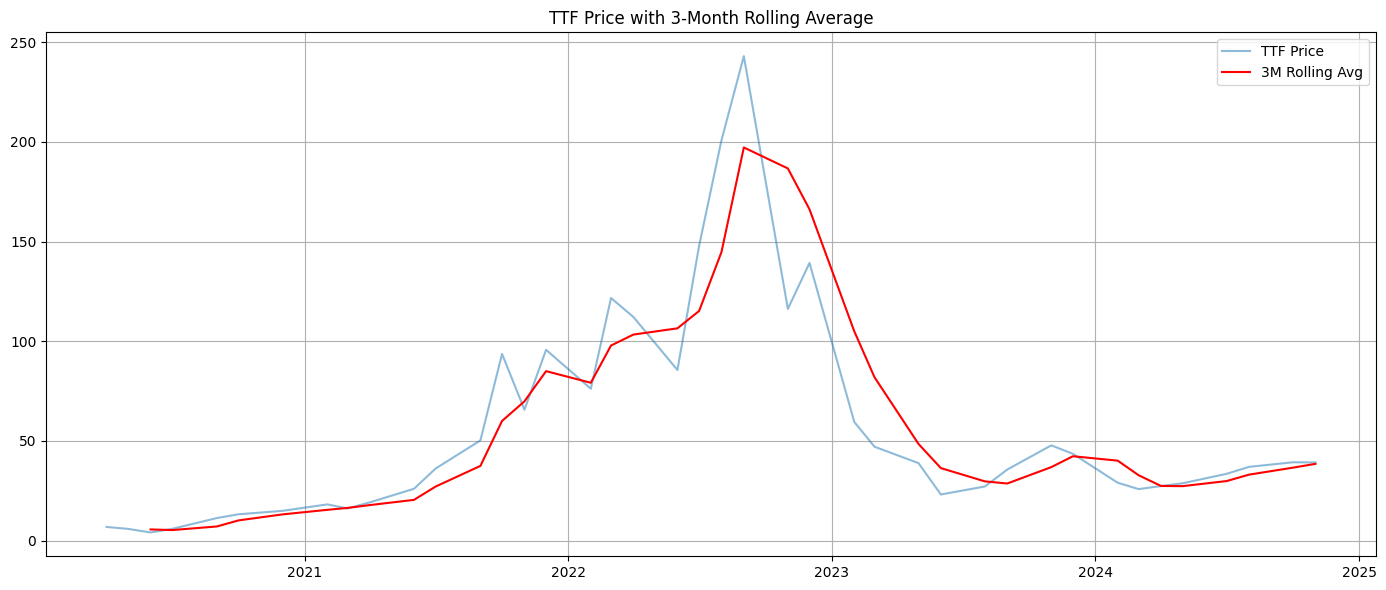

In [64]:
merged_df['TTF_3M_Rolling'] = merged_df['Price_ttf'].rolling(window=3).mean()

plt.figure(figsize=(14,6))
plt.plot(merged_df['Date'], merged_df['Price_ttf'], label='TTF Price', alpha=0.5)
plt.plot(merged_df['Date'], merged_df['TTF_3M_Rolling'], label='3M Rolling Avg', color='red')
plt.title("TTF Price with 3-Month Rolling Average")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Top 5 EU Gas Importers by Volume (Total over time)

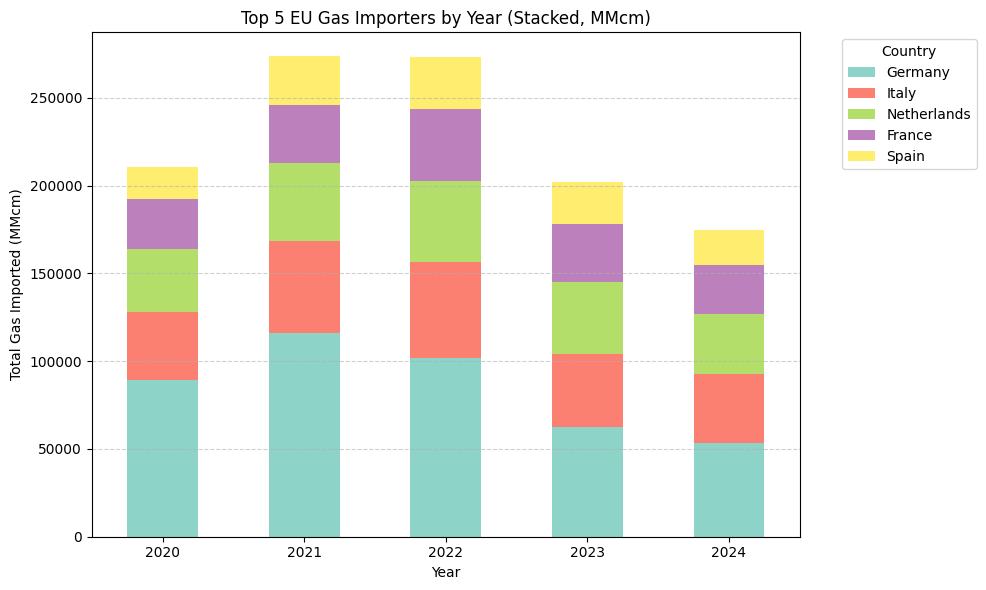

In [65]:
# Step 1: Select and rename columns
top_countries = merged_df[[
    'Date',
    'Germany_gas_imports_mmcm',
    'Italy_gas_imports_mmcm',
    'Netherlands_gas_imports_mmcm',
    'France_gas_imports_mmcm',
    'Spain_gas_imports_mmcm'
]].copy()

top_countries.columns = ['Date', 'Germany', 'Italy', 'Netherlands', 'France', 'Spain']

# Step 2: Extract year and group by year
top_countries['Year'] = top_countries['Date'].dt.year
yearly_totals = top_countries.groupby('Year')[['Germany', 'Italy', 'Netherlands', 'France', 'Spain']].sum()

# Step 3: Plot stacked bar chart
yearly_totals.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set3')
plt.title("Top 5 EU Gas Importers by Year (Stacked, MMcm)")
plt.ylabel("Total Gas Imported (MMcm)")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Feature Engineering

In [66]:
# Select relevant numeric features for feature engineering
features_to_engineer = [
    'Price_ttf',
    'Price_jkm',
    'Avg_Henry_Hub_Price',
    'Liquefied_U.S._Natural_Gas_Exports__Million_Cubic_Feet',
    'Germany_gas_imports_mmcm',
    'Spain_avg_C_temperature'
]

# Apply lag and rolling features
for col in features_to_engineer:
    merged_df[f'{col}_lag1'] = merged_df[col].shift(1)
    merged_df[f'{col}_roll3'] = merged_df[col].rolling(window=3).mean()
    merged_df[f'{col}_pct_change3'] = merged_df[col].pct_change(periods=3)

# Spread features
merged_df['TTF_minus_HH'] = merged_df['Price_ttf'] - merged_df['Avg_Henry_Hub_Price']
merged_df['TTF_minus_JKM'] = merged_df['Price_ttf'] - merged_df['Price_jkm']

# EU-wide average temperature
temp_cols = [col for col in merged_df.columns if '_avg_C_temperature' in col]
merged_df['EU_avg_temp'] = merged_df[temp_cols].mean(axis=1)

# Total EU gas imports
import_cols = [col for col in merged_df.columns if '_gas_imports_mmcm' in col]
merged_df['EU_total_gas_imports'] = merged_df[import_cols].sum(axis=1)

# Rename LNG export column for consistency
merged_df.rename(columns={'Liquefied_U.S._Natural_Gas_Exports__Million_Cubic_Feet': 'US_LNG_exports_mmcf'}, inplace=True)

merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Quarter'] = merged_df['Date'].dt.quarter
merged_df['Year'] = merged_df['Date'].dt.year

# Drop initial rows with NaN values (optional for modeling)
merged_df_fe = merged_df.dropna().reset_index(drop=True)

print("✅ Feature engineering completed.")
merged_df_fe.head()


✅ Feature engineering completed.


,Date,Belgium_gas_imports_mmcm,Bulgaria_gas_imports_mmcm,Czechia_gas_imports_mmcm,Denmark_gas_imports_mmcm,Germany_gas_imports_mmcm,Estonia_gas_imports_mmcm,Ireland_gas_imports_mmcm,Greece_gas_imports_mmcm,Spain_gas_imports_mmcm,...,Spain_avg_C_temperature_lag1,Spain_avg_C_temperature_roll3,Spain_avg_C_temperature_pct_change3,TTF_minus_HH,TTF_minus_JKM,EU_avg_temp,EU_total_gas_imports,Month,Quarter,Year
0,2020-07-01,3704,480,3904,233,12055,16,244,428,2428,...,22.4,23.366667,1.051095,4.1130,3.40625,19.793147,84055.193913,7,3,2020
1,2020-09-01,2430,567,4499,210,11862,18,273,529,3031,...,28.1,23.766667,0.061224,9.3125,6.50625,18.068991,82852.245655,9,3,2020
2,2020-10-01,2680,576,4316,179,12191,22,302,431,2890,...,20.8,20.833333,-0.392857,10.8680,6.75000,13.278373,81621.954809,10,4,2020
3,2020-12-01,3547,638,3129,241,13687,40,314,489,2764,...,13.6,13.833333,-0.747331,12.2725,4.15125,7.040500,83231.135380,12,4,2020
4,2021-02-01,4925,932,3924,205,13710,65,409,898,3088,...,7.1,10.233333,-0.519231,12.4425,11.42525,5.442842,92554.155792,2,1,2021


In [67]:
merged_df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 80 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   Date                                                                38 non-null     datetime64[ns]
 1   Belgium_gas_imports_mmcm                                            38 non-null     int64         
 2   Bulgaria_gas_imports_mmcm                                           38 non-null     int64         
 3   Czechia_gas_imports_mmcm                                            38 non-null     int64         
 4   Denmark_gas_imports_mmcm                                            38 non-null     int64         
 5   Germany_gas_imports_mmcm                                            38 non-null     int64         
 6   Estonia_gas_imports_mmcm                                    

## Build & Evaluate XGBoost Model

✅ Cross-validated R² scores: [-5.443 -2.213  0.672 -1.413  0.698]
📈 Average R²: -1.54

🧪 Test Set Evaluation:
MAE: 1.91
RMSE: 2.615
R²: 0.698


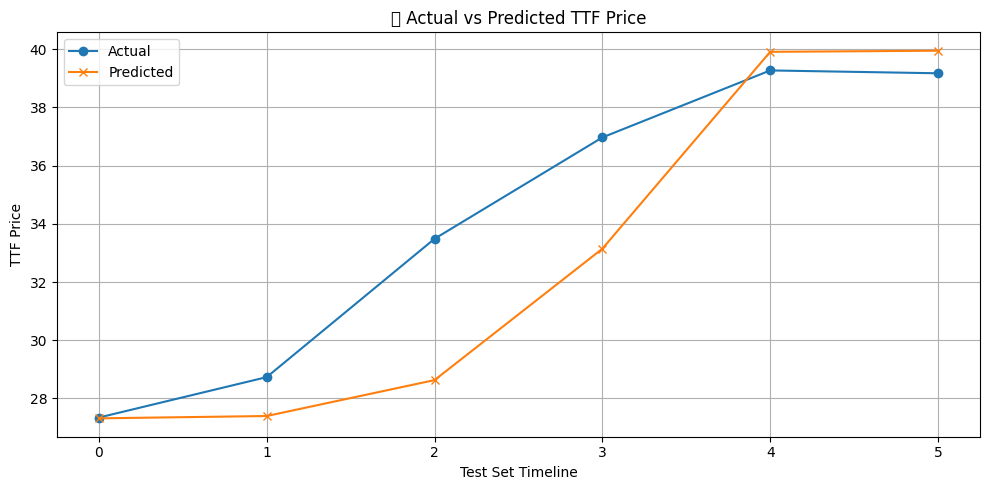

In [68]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Target & Features
target = 'Price_ttf'  # or 'Price' if it's your consolidated target
exclude_cols = ['Date', 'Price', 'Price_ttf', 'Month', 'Year', 'Quarter']  # don't include target or date info
features = [col for col in merged_df.columns if col not in exclude_cols]

X = merged_df[features]
y = merged_df[target]

# TimeSeriesSplit to preserve temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Cross-Validation (R² Score)
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
print("✅ Cross-validated R² scores:", np.round(cv_scores, 3))
print("📈 Average R²:", np.round(cv_scores.mean(), 3))

# Final Train/Test Split (last 6 rows as test)
split_index = len(merged_df) - 6
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Fit & Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("\n🧪 Test Set Evaluation:")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
print("R²:", round(r2_score(y_test, y_pred), 3))

# Optional: Plot Predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('📊 Actual vs Predicted TTF Price')
plt.xlabel('Test Set Timeline')
plt.ylabel('TTF Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Training again using feature importance

In [69]:
#Feature importance
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
top_features = feat_imp.head(10).index.tolist()
print(top_features)

['TTF_minus_HH', 'Price_jkm_lag1', 'Bulgaria_gas_imports_mmcm', 'Estonia_gas_imports_mmcm', 'Avg_Henry_Hub_Price_roll3', 'Italy_gas_imports_mmcm', 'Norway_gas_imports_mmcm', 'Price_jkm_pct_change3', 'Poland_gas_imports_mmcm', 'Germany_gas_imports_mmcm']


In [70]:
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

model_top = XGBRegressor(n_estimators=100, random_state=42)
model_top.fit(X_train_top, y_train)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred2 = model_top.predict(X_test_top)

print(f"MAE: {mean_absolute_error(y_test, y_pred2):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred2, squared=False):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

MAE: 1.83
RMSE: 2.38
R²: 0.698


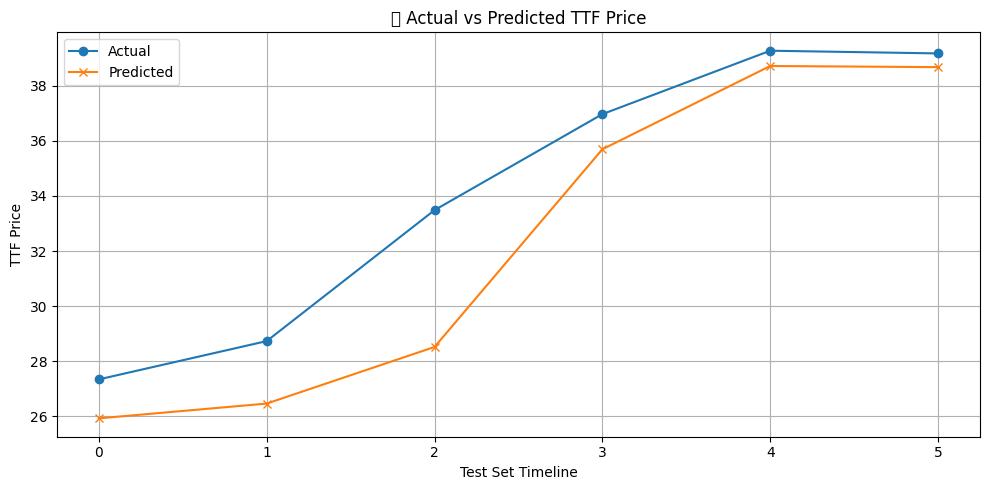

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred2, label='Predicted', marker='x')
plt.title('📊 Actual vs Predicted TTF Price')
plt.xlabel('Test Set Timeline')
plt.ylabel('TTF Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Build & Evaluate Random Forest Model

✅ Cross-validated R² scores (RF): [-5.749 -1.843  0.729  0.657  0.872]
📈 Average R² (RF): -1.067

🧪 Test Set Evaluation (Random Forest):
MAE: 1.344
RMSE: 1.701
R²: 0.872


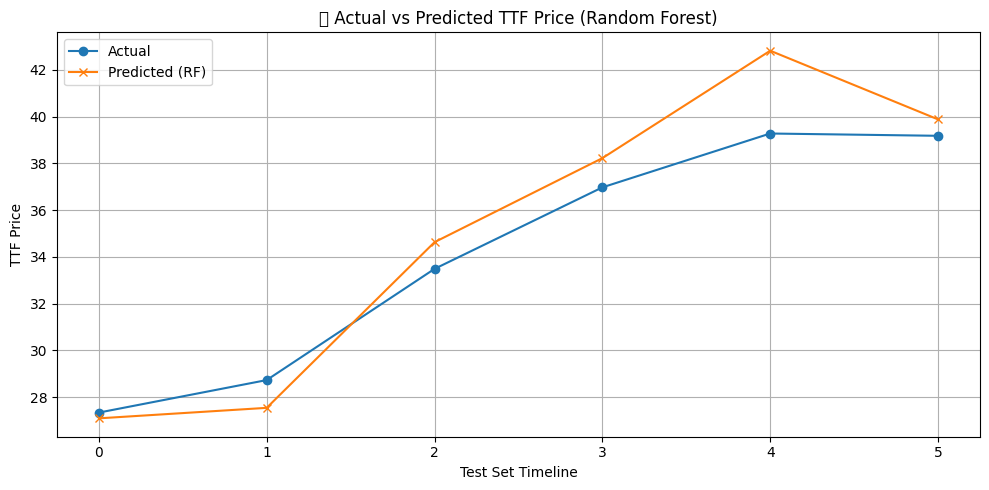

In [80]:
target = 'Price_ttf'
exclude_cols = ['Date', 'Price', 'Price_ttf', 'Month', 'Year', 'Quarter']
features = top_features

# Reconstruct and drop any NaNs (safe step)
df_rf = merged_df[features + [target]].dropna()
X_rf = df_rf[features]
y_rf = df_rf[target]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-Validation
cv_scores = cross_val_score(rf_model, X_rf, y_rf, cv=tscv, scoring='r2')
print("✅ Cross-validated R² scores (RF):", np.round(cv_scores, 3))
print("📈 Average R² (RF):", np.round(cv_scores.mean(), 3))

# Final train-test split
split_idx = len(X_rf) - 6
X_train_rf, X_test_rf = X_rf.iloc[:split_idx], X_rf.iloc[split_idx:]
y_train_rf, y_test_rf = y_rf.iloc[:split_idx], y_rf.iloc[split_idx:]

# Train & predict
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluation
print("\n🧪 Test Set Evaluation (Random Forest):")
print("MAE:", round(mean_absolute_error(y_test_rf, y_pred_rf), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_rf, y_pred_rf)), 3))
print("R²:", round(r2_score(y_test_rf, y_pred_rf), 3))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test_rf.values, label='Actual', marker='o')
plt.plot(y_pred_rf, label='Predicted (RF)', marker='x')
plt.title('📊 Actual vs Predicted TTF Price (Random Forest)')
plt.xlabel('Test Set Timeline')
plt.ylabel('TTF Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
print("🔎 Any NaNs in X?", X_rf.isna().sum().sum())
print("🔎 Any NaNs in y?", y_rf.isna().sum())

🔎 Any NaNs in X? 0
🔎 Any NaNs in y? 0


## Key Market Insights
* TTF consistently trades above Henry Hub due to Europe’s import dependency and higher energy security premiums.
* Post-2020 price divergence is driven by COVID recovery, underinvestment, and the Russia-Ukraine war.
* US LNG exports rose sharply post-2021, correlating with high TTF prices.
* Weather and seasonality influence spot prices — colder months generally see higher TTF levels.
* Arbitrage spreads (TTF − HH) widened significantly, enabling profitable re-routing of LNG cargos.

## 🔍 Model Comparison: Random Forest vs. XGBoost

To evaluate model robustness, we trained both **XGBoost** and **Random Forest** regressors on the same engineered features and temporal train/test splits. Here's a summary of their performance:

| Metric       | XGBoost       | Random Forest  |
|--------------|---------------|----------------|
| MAE          | 1.83          | 1.34           |
| RMSE         | 2.38          | 1.70           |
| R² (Test)    | 0.698         | 0.872          |
| CV R² (Avg)  | -1.54         | -1.07          |

### ✅ Key Observations:
- **Random Forest achieved a better fit on the test set**, with higher R² and lower error metrics.
- However, **both models showed negative average R² in cross-validation**, indicating overfitting due to the small dataset size.
- XGBoost appears to be **more conservative**, while Random Forest **memorized more patterns**, possibly at the cost of generalizability.

---

## ⚠️ Addressing Overfitting

With only ~38 rows of monthly data, traditional machine learning models naturally tend to overfit. Here's how we addressed it:
- Limited the number of engineered features to avoid overparameterization.
- Avoided year-over-year percentage change to preserve data volume.
- Applied **TimeSeriesSplit** cross-validation to mimic real-world forecasting.
- Selected **a small subset of key drivers** based on domain knowledge, not just correlation.

> **Note:** In real-world commodity forecasting, model performance is often secondary to **insight generation, explainability, and integration with scenario planning**.

---

## 🧠 Takeaway
While Random Forest gave stronger test set metrics, both models highlight the limits of predictive power in sparse, high-volatility LNG markets. This reinforces the importance of combining statistical models with **domain expertise, structural insights, and macroeconomic context** — especially in energy forecasting.
